In [2]:
from tqdm import trange
import matplotlib.pyplot as plt

In [3]:
# load data
import numpy as np
import gzip
parse = lambda file: np.frombuffer(gzip.open(file).read(), dtype=np.uint8).copy()
X_train = parse("data/MNIST/raw/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = parse("data/MNIST/raw/train-labels-idx1-ubyte.gz")[8:]
X_test = parse("data/MNIST/raw/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = parse("data/MNIST/raw/t10k-labels-idx1-ubyte.gz")[8:]

In [4]:
import torch 
import torch.nn as nn

class LinearGen(nn.Module):
  def __init__(self):
    super(LinearGen, self).__init__()
    self.l1 = nn.Linear(128, 256)
    self.l2 = nn.Linear(256, 512)
    self.l3 = nn.Linear(512, 1024)
    self.l4 = nn.Linear(1024, 784)
    self.leakyrelu = nn.LeakyReLU(0.2)
    self.tanh = nn.Tanh()
    
  def forward(self, x):
    x = self.leakyrelu(self.l1(x))
    x = self.leakyrelu(self.l2(x))
    x = self.leakyrelu(self.l3(x))
    x = self.tanh(self.l4(x))
    return x

class LinearDisc(nn.Module):
  def __init__(self):
    super(LinearDisc, self).__init__()
    self.l1 = nn.Linear(784, 1024)
    self.l2 = nn.Linear(1024, 512)
    self.l3 = nn.Linear(512, 256)
    self.l4 = nn.Linear(256, 2)
    self.dropout = nn.Dropout(0.3)
    self.leakyrelu = nn.LeakyReLU(0.2)
    self.logsoftmax = nn.LogSoftmax(dim=1)
  
  def forward(self, x, train=True):
    x = self.leakyrelu(self.l1(x))
    if train:
      x = self.dropout(x)
    x = self.leakyrelu(self.l2(x))
    if train: 
      x = self.dropout(x)
    x = self.leakyrelu(self.l3(x))
    if train:
      x = self.dropout(x)
    x = self.logsoftmax(self.l4(x))
    return x

In [5]:
BS = 512 
k = 1 
epochs = 300
n_steps = int(X_train.shape[0]/BS)

In [6]:
def generator_batch(): 
  """random batch from train data"""
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  data_real = X_train[samp].reshape(-1, 28*28).astype(np.float32)/255.
  data_real = (data_real - 0.5) / 0.5
  return torch.tensor(data_real)

def real_label(bs):
  y = np.zeros((bs, 2), np.float32)
  y[range(bs), [1]*bs] = -2.0
  real_labels = torch.tensor(y)
  return real_labels

def fake_label(bs):
  y = np.zeros((bs, 2), np.float32)
  y[range(bs), [0]*bs] = -2.0
  fake_labels = torch.tensor(y)
  return fake_labels

def train_discriminator(optimizer, data_fake, data_real): 
  real_labels = real_label(BS)
  fake_labels = fake_label(BS)
  
  optimizer.zero_grad()
  
  output_real = discriminator(data_real)
  loss_real = (output_real * real_labels).mean()
  
  output_fake = discriminator(data_fake)
  loss_fake = (output_fake * fake_labels).mean()
  
  loss_real.backward()
  loss_fake.backward()
  optimizer.step()
  return loss_real.item() + loss_fake.item()

def train_generator(optimizer, data_fake):
  real_labels = real_label(BS) 
  optimizer.zero_grad()
  out = discriminator(data_fake)
  loss = (out * real_labels).mean()
  loss.backward()
  optimizer.step()
  return loss.item()

epoch loss_g 11.10 loss_d 0.00:  36%|███▌      | 108/300 [1:35:41<2:50:07, 53.16s/it]


KeyboardInterrupt: 

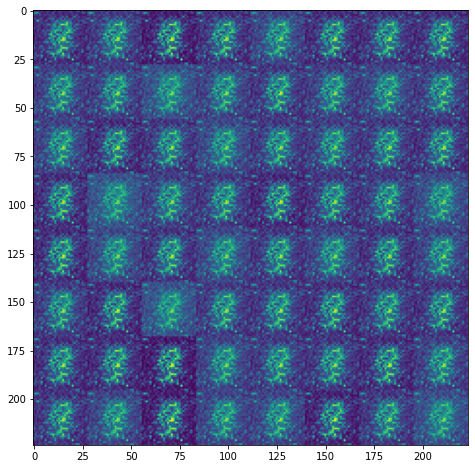

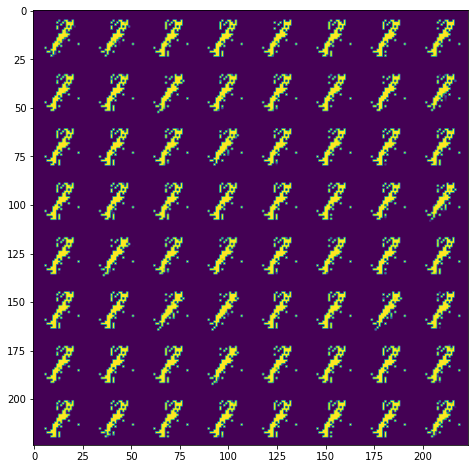

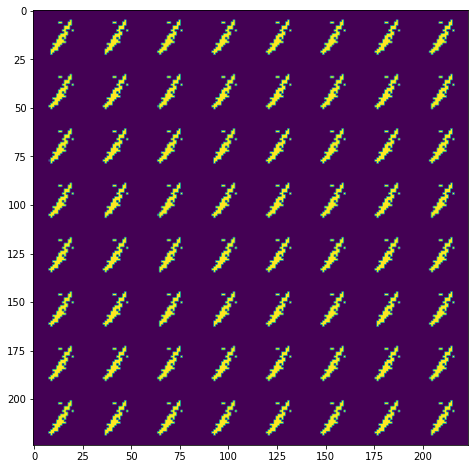

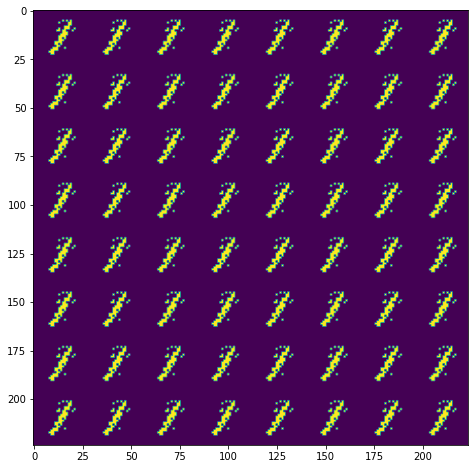

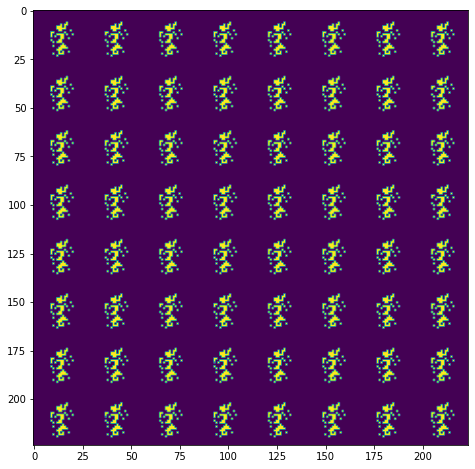

In [13]:
generator = LinearGen()
discriminator = LinearDisc()
optim_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
ds_noise = torch.tensor(np.random.randn(64, 128).astype(np.float32), requires_grad=False)

from torchvision.utils import make_grid
# train
for epoch in (t := trange(epochs)):
  loss_g = 0
  loss_d = 0
  for i in range(n_steps):
    data_real = generator_batch()
    for step in range(k):
      noise = torch.tensor(np.random.rand(BS, 128)).float()
      data_fake = generator(noise).detach()
      loss_d_step = train_discriminator(optim_d, data_fake, data_real)
      loss_d += loss_d_step
    noise = torch.tensor(np.random.randn(BS, 128)).float()
    data_fake = generator(noise)
    loss_g_step = train_generator(optim_g, data_fake)
    loss_g += loss_g_step
  fake_images = generator(ds_noise).detach()
  fake_images = ((fake_images.reshape(-1, 28, 28)+1)/2).numpy()
  fake_images = np.concatenate(fake_images.reshape((8, 8*28, 28)), axis=1)
  if epoch%25 == 0:
    plt.figure(figsize=(8,8))
    plt.imshow(fake_images)
    plt.savefig(f"out/mnist_gan_{epoch}.jpg")
  
  epoch_loss_g = loss_g / n_steps
  epoch_loss_d = loss_d / n_steps
  t.set_description("epoch loss_g %.2f loss_d %.2f" % (epoch_loss_g, epoch_loss_d))

    


(64, 28, 28)
(224, 224)


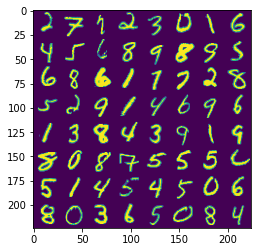

In [233]:
# grid
samp = np.random.randint(0, X_test.shape[0], size=64)
batch = X_test[samp]
print(batch.shape)
batch = np.concatenate(batch.reshape(8, 8*28, 28), axis=1)
print(batch.shape)
plt.imshow(batch)
